# Computational astrophysics
# Final project

In [1]:
# libraries imported 
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
%matplotlib widget
plt.style.use('/Users/dionysisgakis/.config/matplotlib/stylelib/publication.mplstyle') # plotting style, comment out if in another computer

## Problem 1

### HW1, problem 2

Sampling radii...
Sampling velocities (this may take a while)...
0 / 1000000 complete
10000 / 1000000 complete
20000 / 1000000 complete
30000 / 1000000 complete
40000 / 1000000 complete
50000 / 1000000 complete
60000 / 1000000 complete
70000 / 1000000 complete
80000 / 1000000 complete
90000 / 1000000 complete
100000 / 1000000 complete
110000 / 1000000 complete
120000 / 1000000 complete
130000 / 1000000 complete
140000 / 1000000 complete
150000 / 1000000 complete
160000 / 1000000 complete
170000 / 1000000 complete
180000 / 1000000 complete
190000 / 1000000 complete
200000 / 1000000 complete
210000 / 1000000 complete
220000 / 1000000 complete
230000 / 1000000 complete
240000 / 1000000 complete
250000 / 1000000 complete
260000 / 1000000 complete
270000 / 1000000 complete
280000 / 1000000 complete
290000 / 1000000 complete
300000 / 1000000 complete
310000 / 1000000 complete
320000 / 1000000 complete
330000 / 1000000 complete
340000 / 1000000 complete
350000 / 1000000 complete
360000 / 1000

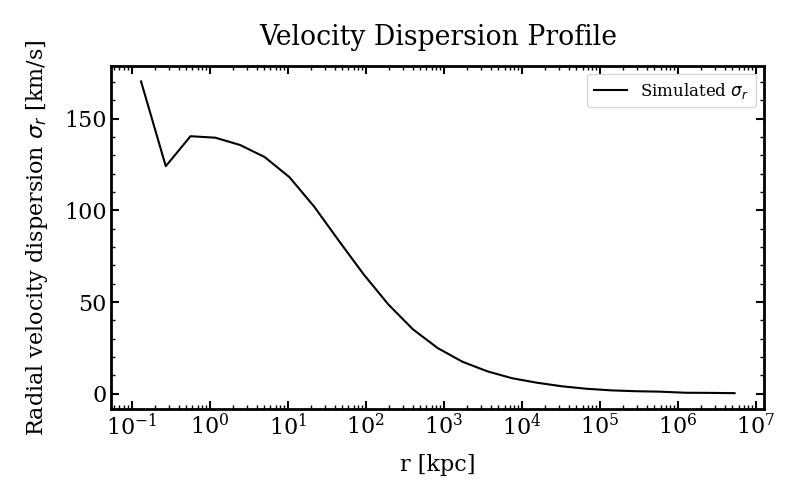

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad

# --- Constants and model parameters ---
G = 4.30091e-6  # Gravitational constant in (kpc * km^2/s^2) / M_sun
M = 1e12        # Total mass in solar masses
a = 35.0        # Scale radius in kpc
N = 10**6       # Number of particles

# --- Gravitational potential and density ---
def potential(r):
    return -G * M / (r + a)

def density(r):
    return (M / (2 * np.pi)) * a / (r * (r + a)**3)

# --- Sample radius from cumulative mass ---
def sample_radius(N):
    u = np.random.uniform(size=N)
    r = a * np.sqrt(u) / (1 - np.sqrt(u))
    return r

# --- Sample isotropic positions uniformly on sphere ---
def sample_positions(r):
    theta = np.arccos(1 - 2*np.random.uniform(size=r.size))
    phi = 2 * np.pi * np.random.uniform(size=r.size)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return np.vstack((x, y, z)).T

# --- Distribution function from Eq. 17 (Hernquist 1990) ---
def f_E(E, GM_a):
    q = np.sqrt(E / GM_a)
    if q >= 1.0:
        return 0
    term1 = 3 * np.arcsin(q)
    term2 = q * np.sqrt(1 - q**2) * (1 - 2*q**2) * (8*q**4 - 8*q**2 - 3)
    return (M / (8 * np.sqrt(2) * np.pi**3 * a**3 * GM_a**1.5)) * (1 / q**2) * (term1 + term2)

# --- Sample velocity magnitude using accept-reject ---
def sample_velocity(r, n_samples=1):
    phi_r = potential(r)
    vmax = np.sqrt(-2 * phi_r)
    GM_a = G * M / a

    velocities = []
    for _ in range(n_samples):
        while True:
            v = np.random.uniform(0, vmax)
            E = -phi_r - 0.5 * v**2
            if E <= 0:
                continue
            q = np.sqrt(E / GM_a)
            if q >= 1.0:
                continue
            f = f_E(E, GM_a)
            if f <= 0:
                continue
            fmax = f_E(-phi_r, GM_a)
            if np.random.uniform(0, fmax) < f:
                velocities.append(v)
                break
    return np.array(velocities)

# --- Sample isotropic velocity vector ---
def sample_velocity_vector(v_mag):
    theta = np.arccos(1 - 2*np.random.rand())
    phi = 2 * np.pi * np.random.rand()
    vx = v_mag * np.sin(theta) * np.cos(phi)
    vy = v_mag * np.sin(theta) * np.sin(phi)
    vz = v_mag * np.cos(theta)
    return np.array([vx, vy, vz])

# --- MAIN ---
print("Sampling radii...")
r = sample_radius(N)
pos = sample_positions(r)

print("Sampling velocities (this may take a while)...")
vel = np.zeros_like(pos)
for i in range(N):
    vmag = sample_velocity(r[i], 1)[0]
    vel[i] = sample_velocity_vector(vmag)
    if i % 10000 == 0:
        print(f"{i} / {N} complete")

# --- Save output ---
np.savez("hernquist_particles.npz", pos=pos, vel=vel)

# --- Velocity dispersion test ---
print("Computing velocity dispersion profile...")
logr_bins = np.logspace(np.log10(np.min(r)), np.log10(np.max(r)), 30)
vr = np.sum(pos * vel, axis=1) / np.linalg.norm(pos, axis=1)
sigma_r = []

for i in range(len(logr_bins)-1):
    mask = (r >= logr_bins[i]) & (r < logr_bins[i+1])
    if np.sum(mask) > 10:
        sigma_r.append(np.std(vr[mask]))
    else:
        sigma_r.append(np.nan)

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(0.5*(logr_bins[1:] + logr_bins[:-1]), sigma_r, label='Simulated $\sigma_r$')
plt.xscale('log')
plt.xlabel("r [kpc]")
plt.ylabel("Radial velocity dispersion $\sigma_r$ [km/s]")
plt.title("Velocity Dispersion Profile")
plt.legend()
plt.tight_layout()
plt.savefig("velocity_dispersion_profile.png")
plt.show()


I also fed the paper in the prompt, so that it has as much info as possible. The resulting plot looks in (very) broad terms similar to the expected one, at least in terms of order of magnitude and the general shape of the plot. However, carefully inspecting the code, it has missed several mathematical details. Being more specific (providing the mathematical procedure) makes it perform better.

### HW2, problem 1

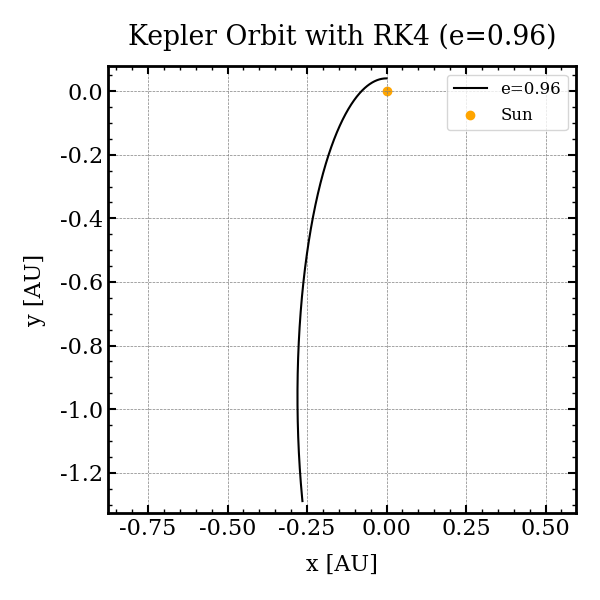

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Constants in natural units (G = M = a = 1)
G = 1.0
M = 1.0
a = 1.0
e = 0.96

# Pericenter and velocity at pericenter
rp = a * (1 - e)
vp = np.sqrt(G * M / a) * np.sqrt((1 + e) / (1 - e))

# Total integration time (1 year)
T = 1.0

# Time step (try dt = 1/12, 1/48, 1/365.25 for comparison)
#dt = 1 / 365.25
dt = 1 / (365.25 * 10)  # 10x smaller

Nsteps = int(T / dt)

# Initial conditions: r = (0, rp), v = (-vp, 0)
y = np.array([0.0, rp, -vp, 0.0])  # [x, y, vx, vy]

def derivatives(y):
    """Compute derivatives [vx, vy, ax, ay] given state y = [x, y, vx, vy]."""
    x, y_pos, vx, vy = y
    r = np.sqrt(x**2 + y_pos**2)
    ax = -G * M * x / r**3
    ay = -G * M * y_pos / r**3
    return np.array([vx, vy, ax, ay])

def rk4_step(y, dt):
    """Perform one RK4 step."""
    k1 = derivatives(y)
    k2 = derivatives(y + 0.5 * dt * k1)
    k3 = derivatives(y + 0.5 * dt * k2)
    k4 = derivatives(y + dt * k3)
    return y + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

# Arrays to store results
trajectory = np.zeros((Nsteps, 4))
trajectory[0] = y

# Integrate
for i in range(1, Nsteps):
    y = rk4_step(y, dt)
    trajectory[i] = y

# Extract x and y for plotting
x_vals = trajectory[:, 0]
y_vals = trajectory[:, 1]

# Plot orbit
plt.figure(figsize=(6, 6))
plt.plot(x_vals, y_vals, label=f'e={e}')
plt.scatter([0], [0], color='orange', label='Sun')
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.axis('equal')
plt.title('Kepler Orbit with RK4 (e=0.96)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The output it gave is significantly accurate. It shows a part of the orbit, but it failed to accurately provide the full orbit. 

### HW 3, Hogg & Foreman-Mackey, problem 2

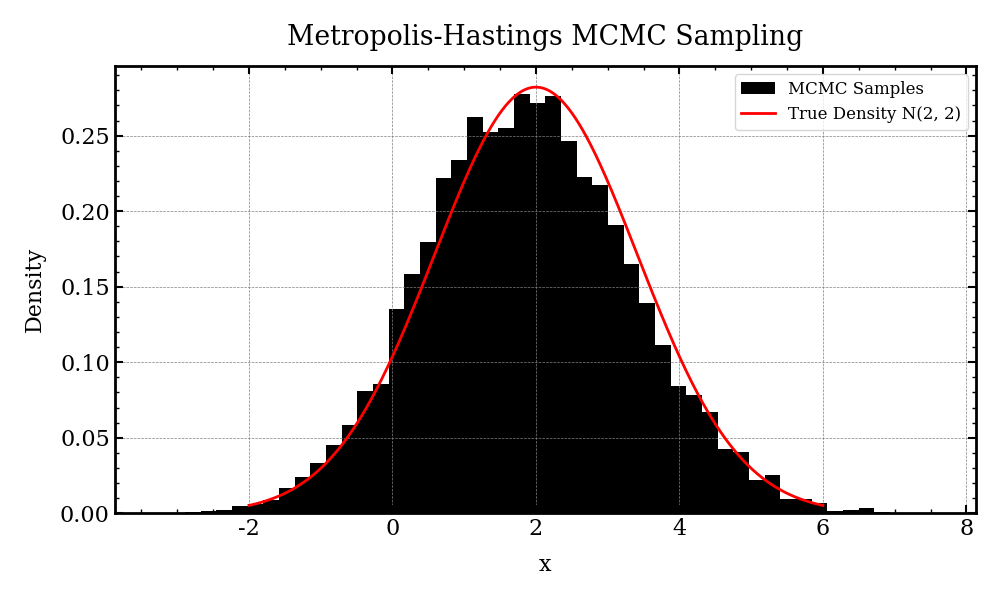

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Target distribution: N(2, 2) ---
def target_density(x):
    return norm.pdf(x, loc=2, scale=np.sqrt(2))

# --- Proposal distribution: N(x_current, 1) ---
def proposal(x_current):
    return np.random.normal(x_current, 1)

# --- Metropolis-Hastings Sampler ---
def metropolis_hastings(target_density, proposal, x_init=0, n_steps=20000):
    samples = []
    x_current = x_init

    for _ in range(n_steps):
        x_proposal = proposal(x_current)

        # Compute acceptance ratio
        acceptance_ratio = target_density(x_proposal) / target_density(x_current)

        # Accept or reject
        if np.random.rand() < acceptance_ratio:
            x_current = x_proposal

        samples.append(x_current)

    return np.array(samples)

# Run sampler
samples = metropolis_hastings(target_density, proposal, x_init=0, n_steps=20000)

# Plot results
x_vals = np.linspace(-2, 6, 500)
true_pdf = norm.pdf(x_vals, loc=2, scale=np.sqrt(2))

plt.figure(figsize=(10, 6))
plt.hist(samples, bins=50, density=True, label='MCMC Samples')
plt.plot(x_vals, true_pdf, 'r-', lw=2, label='True Density N(2, 2)')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Metropolis-Hastings MCMC Sampling')
plt.legend()
plt.grid(True)
plt.show()


It worked pretty accurately here, giving the correct output right away. The problem was more straightforward than in the previous 2 cases though. 

General comments

In general, LLMs are good at providing an initial code or idea, but the output usually needs further modification. They can explain complex topics well, and although the code they generate might need debugging, they can help in that too. However, they might hallucinate libraries or fail to do the task exactly as wanted, so one has to be very specific about what they want. Sometimes, the ideas LLMs suggest might not solve the problem, but in other cases, they might. They are not good at mathematical operations and it’s often times better to manually do the math and provide the results. That said, the field is evolving rapidly, with dramatic increases in quality over just a few months, so this my answer might change within the next few months/years! In general though, LLMs cannot truly replace the human mind so far, but can act as an extremely useful tool to speed up several tedious tasks.

## Problem 2

In [5]:
import numpy as np
from scipy.spatial import cKDTree
import time
from numba import njit, prange # with Numba
import matplotlib.pyplot as plt
import os
os.environ["OMP_DISPLAY_ENV"] = "FALSE" # don't get warnings from Numba

G = 1.0
softening = 0.0001
seed = 8675309

def random_positions(N, seed=8675309):
    rng = np.random.RandomState(seed)
    return rng.uniform(0, 100, size=(N, 3))

@njit(parallel=True)
def accelerations_directly_numba(pos): 
    N = len(pos)
    acc = np.zeros((N, 3))
    for i in prange(N):
        ax, ay, az = 0.0, 0.0, 0.0
        for j in range(N):
            if i == j:
                continue # avoid self-interaction
            dx = pos[j, 0] - pos[i, 0]
            dy = pos[j, 1] - pos[i, 1]
            dz = pos[j, 2] - pos[i, 2]

            # periodic boundary conditions
            # Logic: if the distance is greater than 50, we are closer to the other side of the box
            # than the current side, so we need to subtract 100 from the distance
            # to get the correct distance
            if dx > 50:
                dx -= 100
            elif dx < -50:
                dx += 100
            if dy > 50:
                dy -= 100
            elif dy < -50:
                dy += 100
            if dz > 50:
                dz -= 100
            elif dz < -50:
                dz += 100

            r2 = dx*dx + dy*dy + dz*dz + softening**2
            inv_r3 = 1.0 / (r2 * np.sqrt(r2))
            ax += dx * inv_r3
            ay += dy * inv_r3
            az += dz * inv_r3 
        acc[i, 0] = G * ax
        acc[i, 1] = G * ay
        acc[i, 2] = G * az
    return acc

Ns = [10**5] # number of particles tested
times_direct = []

for N in Ns:
    print(f"\nN = {N}")
    pos = random_positions(N, seed=seed)

    # Numba-accelerated direct method
    start = time.time()
    acc_direct = accelerations_directly_numba(pos)
    times_direct.append(time.time() - start)
    print(f"Direct (Numba) time: {times_direct[-1]:.2f} s")



N = 100000


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Direct (Numba) time: 9.47 s


Originally, with non-periodic conditions, for N = 100000 the Direct (Numba) time was 4.47 s, so the periodic conditions double the time.

For KDTree, I would have to check if some the neighbors found are near the borders, in which case their closest neighbor might be a particle from the other side of the box. Respectively, when finding the closest neighbors for a specific particle, we might have to include some particles from the other side of the box. All those imply some check across the edges of the box, and adjusting for the true shortest path.